# PUC-Rio 
## Departamento de Engenharia Elétrica
## Trabalho 3 - Mapas de Kohonen

Estudante: Felipe da Costa Pereira

In [23]:
!git clone https://github.com/mdrs-thiago/minisom

fatal: destination path 'minisom' already exists and is not an empty directory.


In [24]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
from sklearn.preprocessing import minmax_scale, MaxAbsScaler, RobustScaler, StandardScaler, MinMaxScaler

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tqdm.notebook as tqdm

from minisom.minisom import MiniSom
from itertools import product


In [7]:
filePath = os.getcwd()+'\\datasets'+'\\class_thyroid.csv'
dataset = pd.read_csv(filePath)

In [8]:
X = dataset.values[:,:-1]
X.shape

(215, 5)

Functions for saving and retrieving a som from disk

In [75]:
import pickle
  
def save_som(som, filename):
    '''
    function to save a som or a dictionary to disk
    
    ## INPUTS:
    som: som object (or anything, for exemple a dictionary)
    filename - file name
    '''
    som_file = open(filename, 'ab')
    pickle.dump(som, som_file)                     
    som_file.close()
  
def load_som(filename):
    '''
    function to read a som saved to disk
    
    ## INPUTS:
    filename - file name
    ## RETURNS:
    som: som object (or anything, for exemple a dictionary)
    '''
    # for reading also binary mode is important
    som_file = open(filename, 'rb')     
    som = pickle.load(som_file)
    som_file.close()
    return som

## Parte 1 - Testando configurações

Nesta primeira etapa, iremos investigar como a configuração do mapa pode mudar de acordo com a escolha de parâmetros. 

##### 1. Escolha os parâmetros para o primeiro teste usando SOM. Para cada parâmetro, justifique sua escolha. Avalie o resultado.

In [10]:
#Dimensão do vetor de entrada
input_len = X.shape[1]
X = minmax_scale(X)

topology = 'hexagonal'
# topology = 'rectangular'

# map dimensions
m = 18
n = 18

###############################
###############################
# 1a fase - Ordering Phase
###############################
###############################
ordering_lr = 1
ordering_time = 10000

# decay function 
def decay_fcn_ordering(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    new_lr = lr/(1 + 2*actual_t/max_t)
    return new_lr

###############################
###############################
# 2a fase - Fine Adjustment Phase 
#   Ideally alpha < 0.02 and constant
###############################
###############################
finetuning_lr = 0.02 # constant
finetuning_time = 500 * m * n
# finetuning_time = 5000

# decay function 
def decay_fcn_finetuning(lr,actual_t,max_t):
    return lr

Model builder

In [51]:
som = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering)
som.pca_weights_init(X)


In [52]:
som._sigma, som._learning_rate

(1.0, 1)

In [53]:
# name to be retrieved after
somname_file = f'som_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn'

Ordering Phase Training

In [234]:
som.train_random(X, ordering_time, verbose=True)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.008291547222253766
Topographic error not computed.


In [235]:
som._sigma, som._learning_rate

(1.0, 1)

In [221]:
quant_err = som._quantization_error
topo_err = som._topographic_error

Finetuning phase Training

___
Sigma também tem que ser atualizado pois estava retornando pra 1 depois da fase de ordenação, quando é esperado um decaimento a um terço do seu valor inicial

In [236]:
som._learning_rate = finetuning_lr
som._decay_function = decay_fcn_finetuning

# ao final do treino de ordenalçao, sigma deve valer um terço do inicial. (new_lr = lr/(1 + 2*actual_t/max_t)
som._sigma = som._sigma / 3

In [237]:
som.train_random(X, finetuning_time, verbose=True)

 [ 162000 / 162000 ] 100% - 0:00:00 left 
 quantization error: 0.007256318106327761
Topographic error not computed.


Cumulating quantization and topographic errors in both phases

In [238]:
quant_err += som._quantization_error
topo_err += som._topographic_error

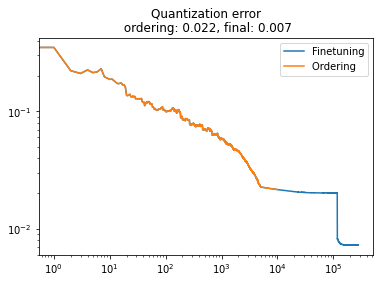

In [239]:
plt.plot(quant_err)
plt.plot(quant_err[:ordering_time])
plt.legend(['Finetuning','Ordering '])
plt.title(f'Quantization error\n ordering: {np.min(quant_err[:ordering_time]):.3f}, final: {quant_err[-1]:.3f}')
plt.xscale('log')
plt.yscale('log')
plt.savefig(somname_file+'_qerr.png')
pass;

In [207]:
if topo_err:  # não está mais sendo calculado para hexagonal
    plt.plot(topo_err)
    plt.plot(topo_err[:ordering_time])
    plt.legend(['Finetuning','Ordering '])
    plt.title(f'Topographical error\n finetuning min: {np.min(topo_err[ordering_time:]):.3f}, final: {topo_err[-1]:.3f}')
    plt.xscale('log')
    plt.savefig(somname_file+'_terr.png')
pass;

0.28867513459481287


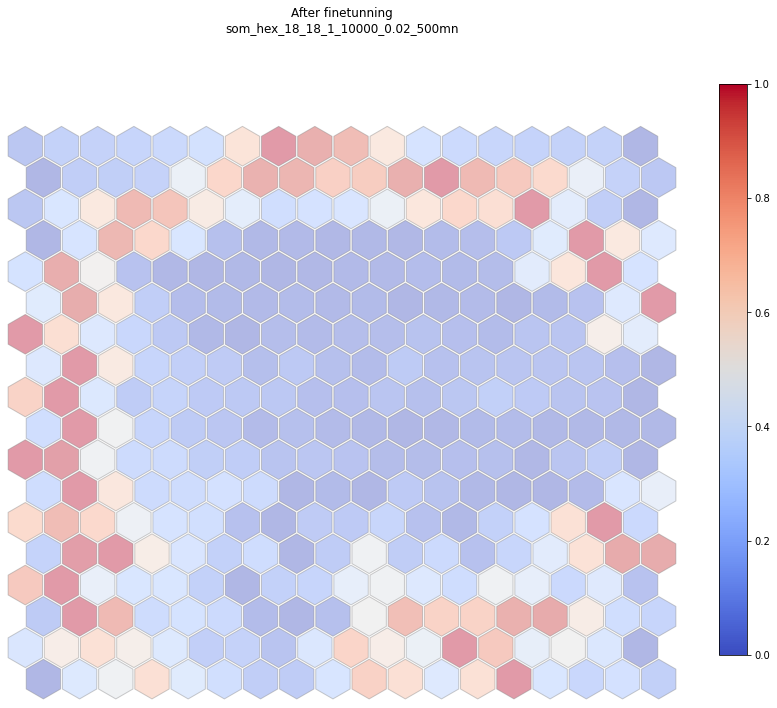

In [240]:
som.plot_umatrix(names=[f'After finetunning\n{somname_file}'])

Saving som to disk

In [242]:
save_som(som, somname_file)
somname_file

'som_hex_18_18_1_10000_0.02_500mn'

Treinando vários modelos, influencia de m x n

In [13]:
m_ = [10,12,16,20,25,30,40,30]
n_ = [10,12,16,20,18,20,20,30]

combinations = zip(m_,n_)
combinations = list(combinations)

n_models = len(combinations)

print ('treinaremos', n_models, 'modelos')


treinaremos 8 modelos


In [ ]:
dict_mn = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i, (m_, n_) in enumerate(combinations):
    print (f'\n model {i+1} / {len(combinations)} ({(i+1)*100/n_models:.1f}%)')

    newsom = MiniSom(m_,n_,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1)
    
    newsom.pca_weights_init(X)
    newsom.train_random(X, ordering_time, verbose=False)

    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m_*n_, verbose=False)

    dict_mn['som'].append(newsom)
    dict_mn['q_err'].append(newsom._quantization_error[-1])
    dict_mn['params'].append((m_, n_))

    print (f'>>>>>>>>> params={(m_, n_)}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')
    pass;

In [32]:
save_som(dict_mn, 'soms_dict_p1_item_1.dict')

In [22]:
for i, d in enumerate(dict_mn['som']):
    p = dict_mn['params'][i]    
    q = dict_mn['q_err'][i]
    print (f'model={i+1} params={p} q_err={q:.4f}')

model=1 params=(10, 10) q_err=0.0366
model=2 params=(12, 12) q_err=0.0213
model=3 params=(16, 16) q_err=0.0082
model=4 params=(20, 20) q_err=0.0052
model=5 params=(25, 18) q_err=0.0047
model=6 params=(30, 20) q_err=0.0045
model=7 params=(40, 20) q_err=0.0038
model=8 params=(30, 30) q_err=0.0028


In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_mn['som']):
    p = dict_mn['params'][i]    
    q = dict_mn['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])
    pass;

Todos os mapas treinados forams salvos em formato imagens

> #### Resposta:
> Justificativa para as escolhas:  
> 
> 1.1 **Etapa de treinamento de ordenação**: Na etapa de ordenação, utilizei uma taxa de aprendizagem de 1, já que o algoritmo prevê o seu decaimento. Para o tempo de treinamento, selecionei 10000 épocas (em algumas vezes o treinamento acabou antes) e para a função de decaimento utilizei a função fornecida.
> 
> 1.2 **Etapa de treinamento de ajuste fino**:  Na etapa de finetuning, utilizei uma taxa de aprendizagem baixa (entre 0.005 e 0.02). Para o tempo de treinamento, selecionei de 500x a 700x o número de processadores. Para a função de decaimento, utilizei uma que mantém a taxa de aprendizado constante.
> 
> 1.3 **Dimensões do mapa**: Conforme figura abaixo, percebemos que mapas pequenos, da ordem de 10x10 deixavam apenas uma região, sendo o mapa mais homogeneo. Já quando aumentei o numero de neuronios do mapa para da ordem de 40x40 ou 40x20, houve nítido ganho na identificação de agrupamentos, mas o treinamento se tornou muito custoso. Então fui progressivamente reduzindo o mapa mas tentando permanecer com heterogeneidade dentro da área central do mapa. Cheguei na dimensão da ordem de mxn = 16x16 como sendo promissor para separação em gupos e tempo de treinamento factível para realizar novos testes. Seguiremos com ele para as próximas análises como um caso de referência.

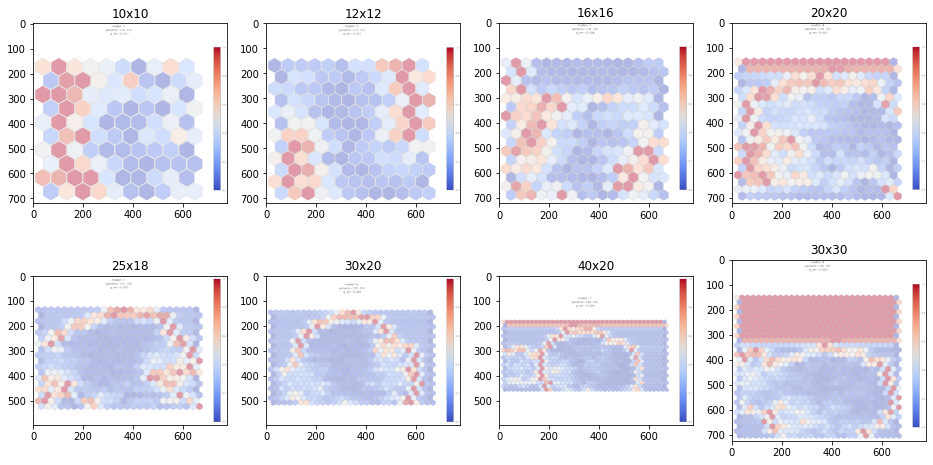

In [55]:
maps_dims = ['10x10','12x12','16x16','20x20','25x18','30x20','40x20','30x30']

f,axs = plt.subplots(2,4, figsize=(16,8))
axs = axs.flatten()
for i in range(8):
    img = mpimg.imread('./map_images/map_p1_i1_'+str(i+1)+'.png')
    axs[i].imshow(img)
    axs[i].set(title=maps_dims[i])

Após selecionado o mapa de 16x16, essa seria a interpretação das fronteiras dos grupos e dos possíveis clusters, onde seria possível identificar 3 ou 4 grupos

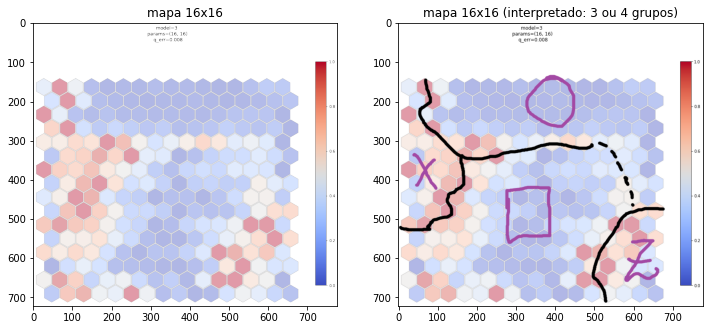

In [76]:
f,axs = plt.subplots(1,2, figsize=(12,6))
axs = axs.flatten()

img = mpimg.imread('./map_images/map_p1_i1_3.png')
axs[0].imshow(img)
axs[0].set(title='mapa 16x16')

img = mpimg.imread('./map_images/map_p1_i1_3i.png')
axs[1].imshow(img)
axs[1].set(title='mapa 16x16 (interpretado: 3 ou 4 grupos)')
pass;


Avaliando quais features estão associadas ao agrupamento.  

0.28867513459481287
0.28867513459481287
0.28867513459481287
0.28867513459481287
0.28867513459481287


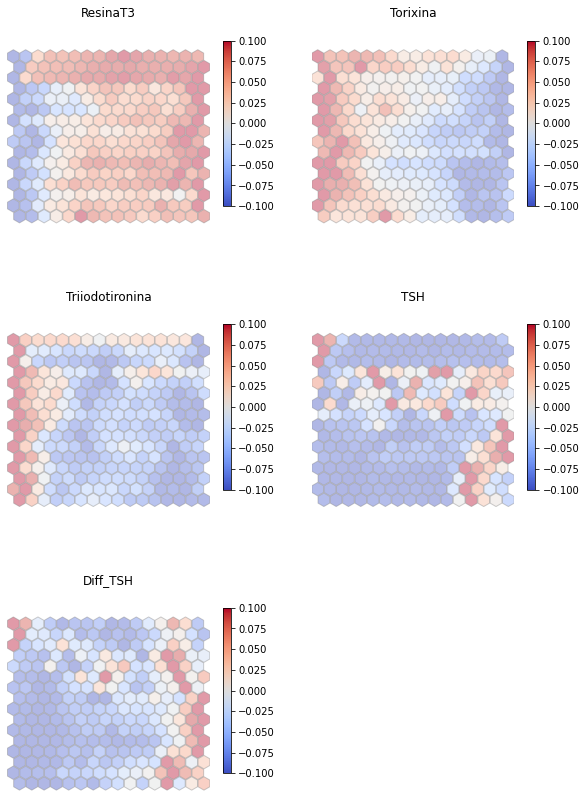

In [59]:
som_16 = dict_mn['som'][2] #16x16
som_16.plot_map(4, 2,feature_names = dataset.columns[:-1], size=(10,20), normalize_weights = True, um = False)

Os atributos 4 e 5 ('TSH', 'Diff_TSH') parecem dominar a parte inferior direita do mapa. Porém no mapa de distâncias, na parte superior e esquerda do mesmo, interpreta-se uma contribuição dos atributos 2 e 3 ('Torixina', 'Triiodotironina')

<AxesSubplot:>

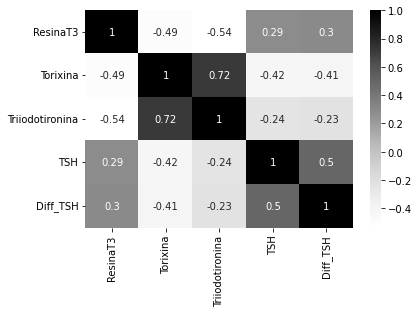

In [61]:
sns.heatmap(dataset.iloc[:,:-1].corr(), annot=True, cmap='Greys')

Percebemos que as features 2/3, assim como 4/5 possuem razoável grau de correlação, daí sua semelhança no mapa.

##### 2. Modifique a topologia da rede. Teste diferentes valores e avalie o resultado.

Para o numero de processadores (tamanho do mapa), selecionamos um tamanho de rede de 16x16 conforme avaliado na respota 1.3, o que seria um caso intermediário com possibilidade de separação em clusters e com tempo de trenamento razoável.    

Vamos agora fixar esse mapa e proceder avaliaçao do parâmetro sigma, que está relacionado ao tamanho da vizinhança.   

Vamos fixar uma **random seed** para garantir a comparação, eliminando o efeito estocástico entre todas as realizações

In [67]:
sigmas = [0.2, .5, 1, 3]
rs=222
m=16
n=16
n_models = len(sigmas)

In [74]:
dict_sigma = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

for i,sigma in enumerate(sigmas):

    print (f'\n model {i+1} / {n_models} ({(i+1)*100/n_models:.1f} %)')

    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=sigma, random_seed=rs)
    newsom.pca_weights_init(X)
    newsom.train_random(X, 10000, verbose=False)
   
    newsom._learning_rate = finetuning_lr
    newsom._decay_function = decay_fcn_finetuning
    newsom._sigma = newsom._sigma / 3

    newsom.train_random(X, 500*m*n, verbose=False)

    dict_sigma['som'].append(newsom)
    dict_sigma['q_err'].append(newsom._quantization_error[-1])
    dict_sigma['params'].append(sigma)

    print (f'>>>>>>>>> params={sigma}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')

# a função save_som() tambem pode salvar um dict
save_som(dict_sigma, 'soms_dict_p1_item_2.dict')
    
pass;


 model 1 / 4 (25.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=0.2
>>>>>>>>> q_err=0.1159

 model 2 / 4 (50.0 %)
Topographic error not computed.


c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


Topographic error not computed.
>>>>>>>>> params=0.5
>>>>>>>>> q_err=0.0462

 model 3 / 4 (75.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=1
>>>>>>>>> q_err=0.0089

 model 4 / 4 (100.0 %)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=3
>>>>>>>>> q_err=0.0487


salvando caso de referencia para comparação nos próximos testes

In [ ]:
# Looping para printar os mapas em formato imagem e salvar, para depois fazer um subplots
for i, s in enumerate(dict_sigma['som']):
    p = dict_sigma['params'][i]    
    q = dict_sigma['q_err'][i]
    s.plot_umatrix(names=[f'model={i+1} \n params={p} \n q_err={q:.3f}'])
    pass;

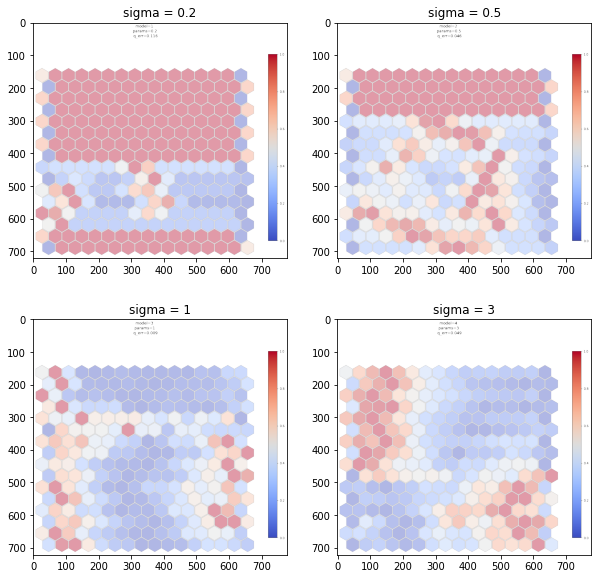

In [80]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

for i in range(4):
    img = mpimg.imread('./map_images/map_p1_i2_'+str(i+1)+'.png')
    axs[i].imshow(img)
    axs[i].set(title=f'sigma = {sigmas[i]}')


In [245]:
som_ref = dict_sigma['som'][2]

#### Resposta:

> Quando sigma é pequeno, o mapa fica com muitos processadores que não se movimentaram durante o treinamento. Já quando sigma é grande, o mapa tende a ficar homogêneo dado que o raio da vizinhança dos BMUs aumenta e muitos processadores se movem simultaneamente.
>
> Para sigma=5, observa-se um padrão no mapa como se apenas dois BMUs tivessem levado todos os seus vizinnhos para as regioes 'noroeste' e 'sudeste' do mapa. Apesar do valor muito alto, sugere um padrão interessante para definição de grupos no mapa. 

##### 3. Modifique a normalização dos dados de entrada e avalie o resultado obtido. Esta mudança tem algum efeito no mapa gerado?

Treinando com normalização standard e com sigma =1 e rs=222 para comparação (todos os demais parâmetros idênticos)

In [171]:
scalers = [
('Standard Scaler', StandardScaler()),
('Min,Max = (-1,1)', MinMaxScaler(feature_range=(-1,1))),
('Robust', RobustScaler()),
]
for scaler in np.asarray(scalers):
    print (scaler[1].get_params())


{'copy': True, 'with_mean': True, 'with_std': True}
{'clip': False, 'copy': True, 'feature_range': (-1, 1)}
{'copy': True, 'quantile_range': (25.0, 75.0), 'unit_variance': False, 'with_centering': True, 'with_scaling': True}


 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.05497944944019062
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.308213827448402
Topographic error not computed.
0.28867513459481287


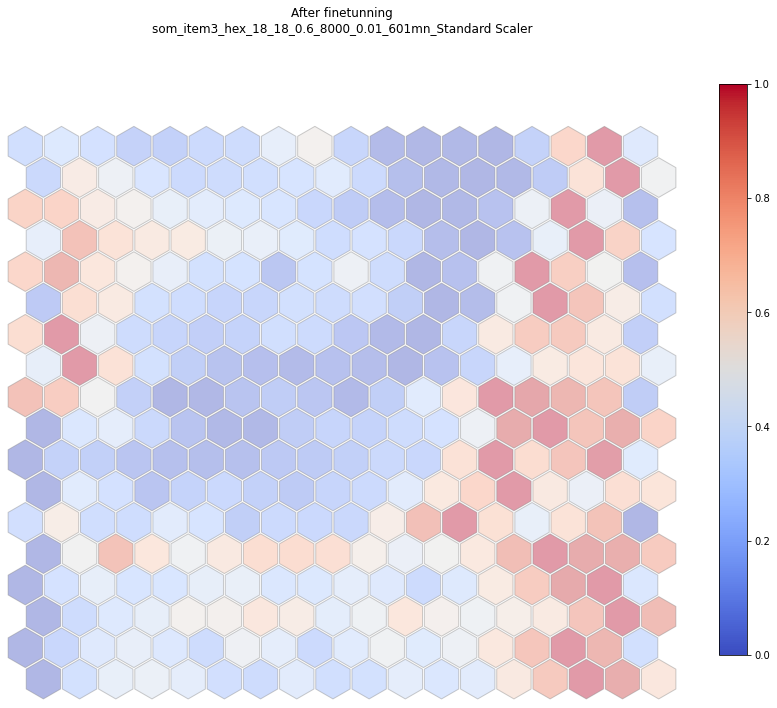

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.056384748293103054
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.11377123962884812
Topographic error not computed.
0.28867513459481287


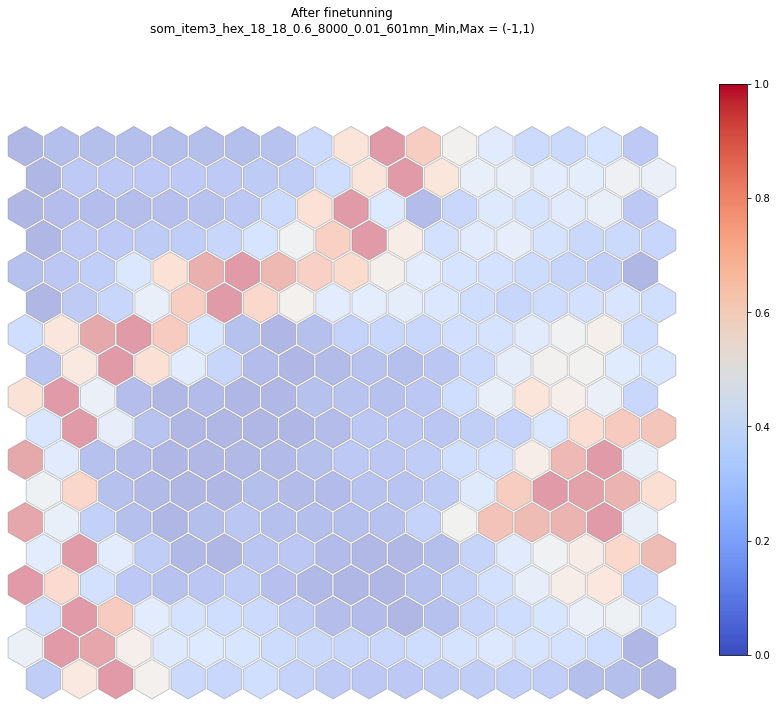

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.09532732390828379
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.6719539320958106
Topographic error not computed.
0.28867513459481287


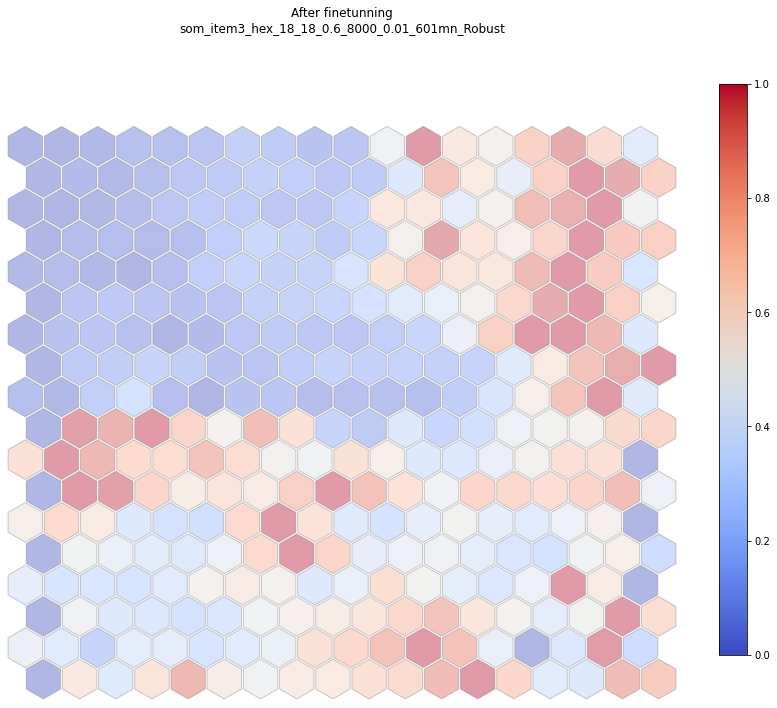

In [172]:
rs=222
soms_scalers = [] #salvar modelos

for scaler in scalers:
    XIN = scaler[1].fit_transform(X)

    s = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    s.pca_weights_init(XIN)

    sname_file = f'som_item3_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn_{scaler[0]}'

    s.train_random(XIN, ordering_time, verbose=True)

    s._learning_rate = finetuning_lr
    s._decay_function = decay_fcn_finetuning

    s.train_random(XIN, finetuning_time, verbose=True)

    s.plot_umatrix(names=[f'After finetunning\n{sname_file}'])
    soms_scalers.append(s)

    save_som(s, sname_file)
    sname_file

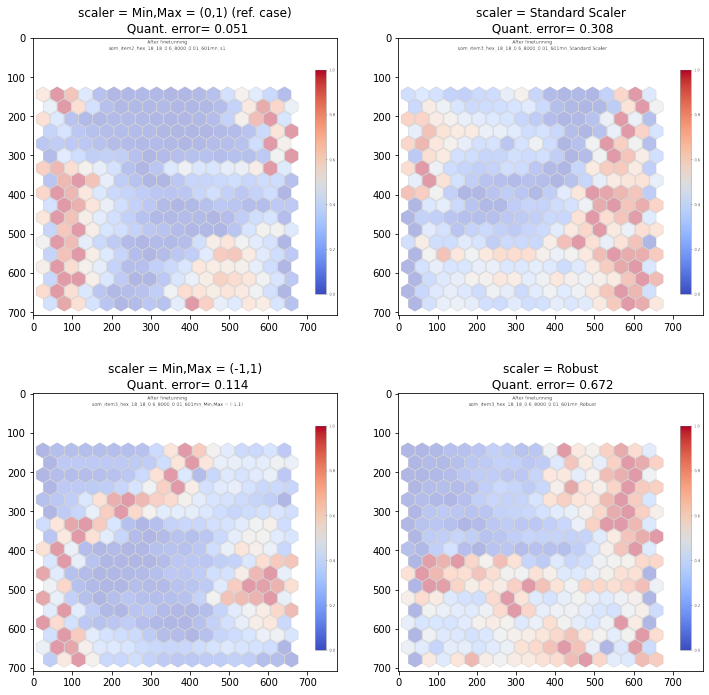

In [248]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

qerrs = [m._quantization_error[-1] for m in soms_scalers]

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'scaler = Min,Max = (0,1) (ref. case)\n Quant. error= {som_ref._quantization_error[-1]:.3f}')

for i in range(3):
    img = mpimg.imread('./maps/item3.'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'scaler = {scalers[i][0]}\n Quant. error= {qerrs[i]:.3f}')

#### Resposta:

> Os mapas obtidos pelos métodos StandardScaler e RobustScaler e MinMax (-1,1) apresentam resultados bem diferentes em relação ao método MinMaxScaler (0,1). O parâmetro quantization error tem seu valor mais baixo para os normalizadores MinMax, sendo que intuitivamente o Min,Max sugere uma boa separação em clusters.

##### 4. Modifique o processo de treinamento durante a fase de ordenação. Avalie o resultado gerado.

Vamos realizar uma sensibilidade dos mapas à taza de aprendizado da fase de ordenação.

In [174]:
ordering_learning_rates = [0.01, 0.1, 0.5, 0.8, 1]

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.11628399231125583
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.04869708247925561
Topographic error not computed.
0.28867513459481287


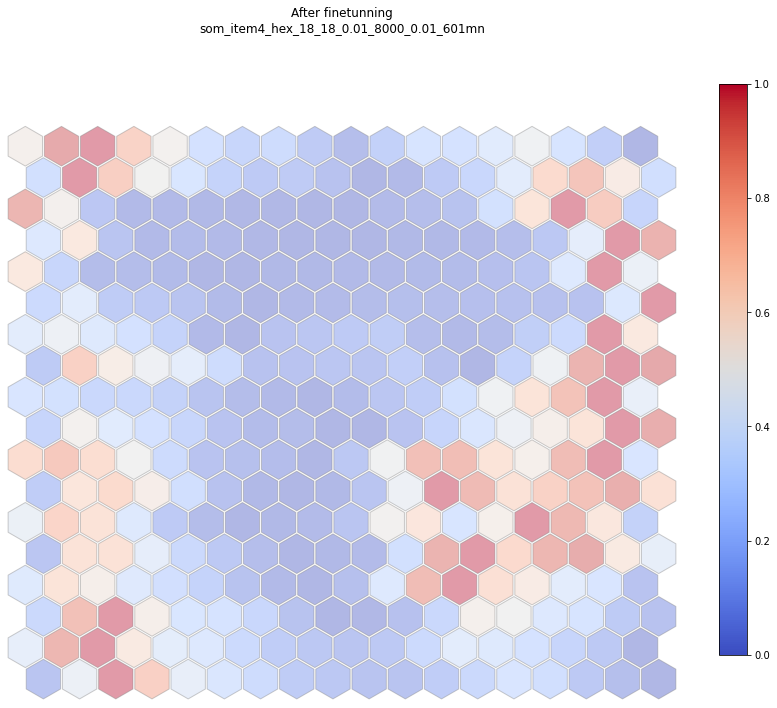

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.04987155622107317
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.05115706063960506
Topographic error not computed.
0.28867513459481287


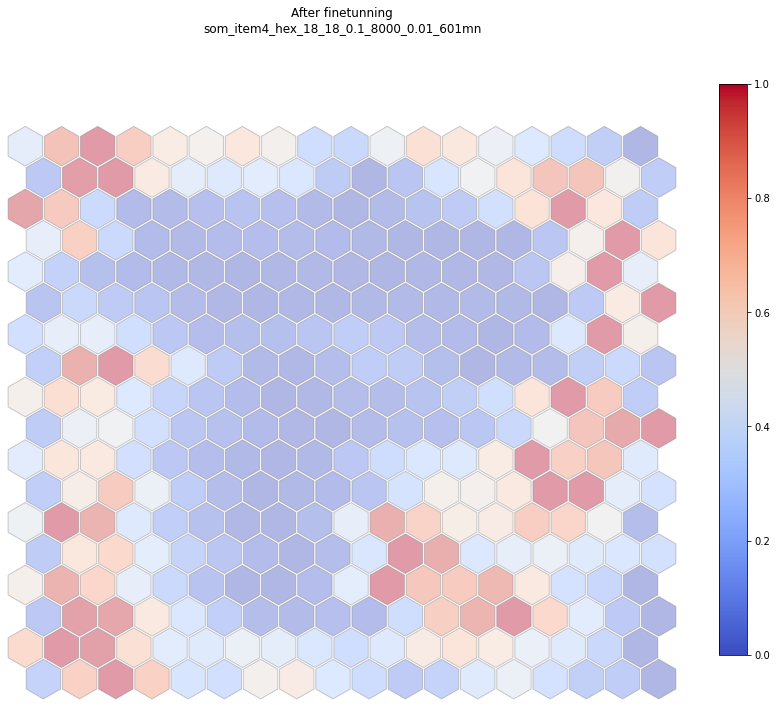

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.01867358222828662
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.04963676686448259
Topographic error not computed.
0.28867513459481287


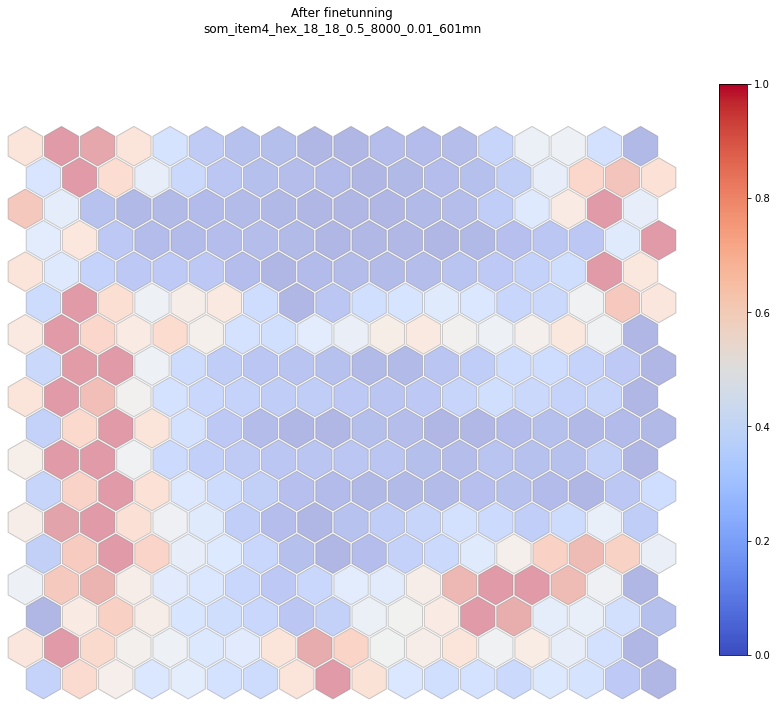

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.012405854081457097
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.05161572665006001
Topographic error not computed.
0.28867513459481287


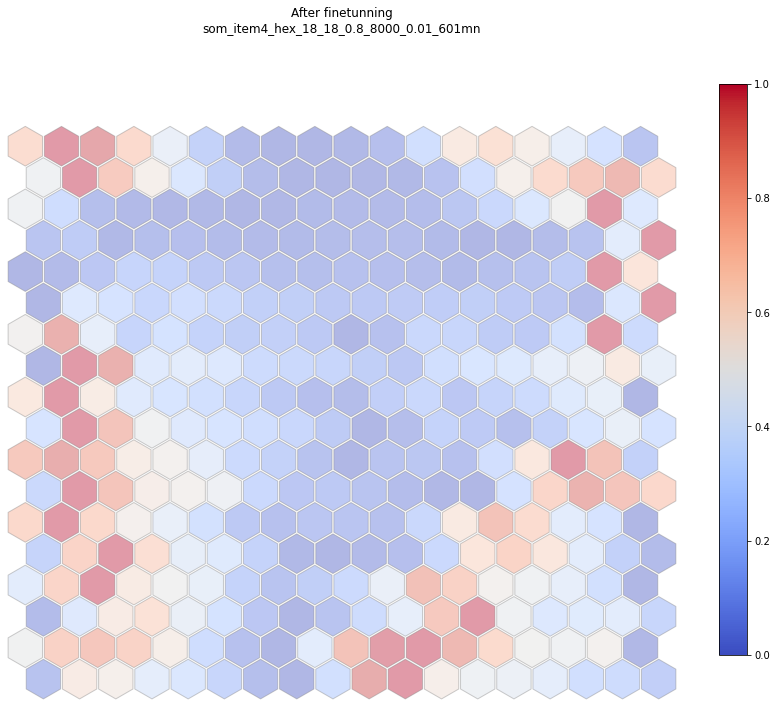

 [   54 / 8000 ]   1% - 0:00:26 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.010170060582152361
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.04691283529067439
Topographic error not computed.
0.28867513459481287


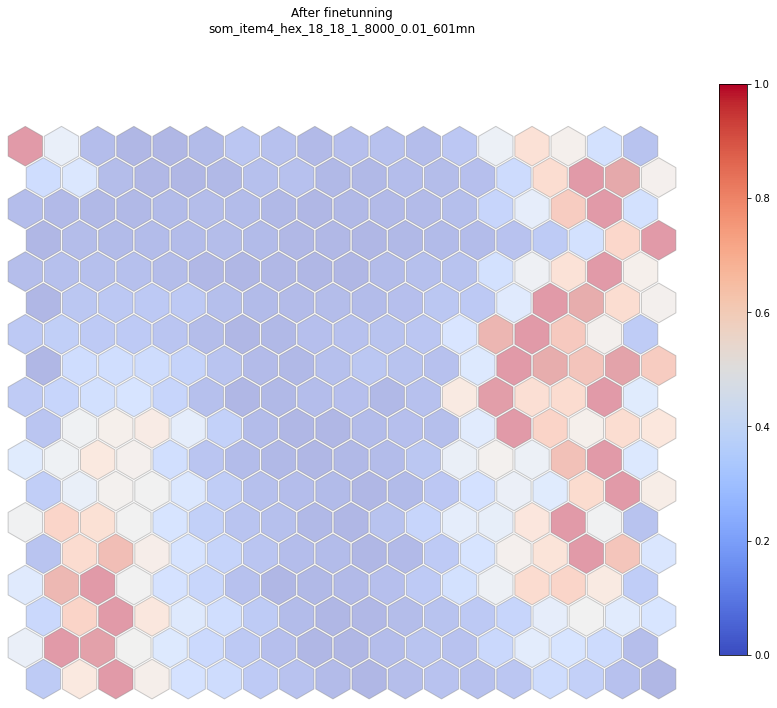

In [175]:
rs=222
soms_ordering_training = [] #salvar modelos

for lr in ordering_learning_rates:
    s = MiniSom(m,n,input_len,learning_rate=lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    s.pca_weights_init(X)

    sname_file = f'som_item4_{topology[:3]}_{m}_{n}_{lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn'

    s.train_random(X, ordering_time, verbose=True)

    s._learning_rate = finetuning_lr
    s._decay_function = decay_fcn_finetuning
    
    s.train_random(X, finetuning_time, verbose=True)

    s.plot_umatrix(names=[f'After finetunning\n{sname_file}'])
    soms_ordering_training.append(s)

    save_som(s, sname_file)
    sname_file

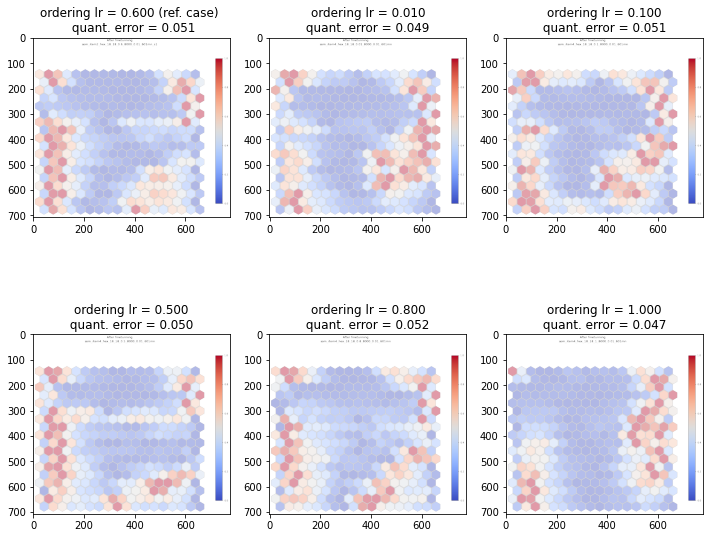

In [176]:
f,axs = plt.subplots(2,3, figsize=(12,10))
axs = axs.flatten()

qerrs = [m._quantization_error[-1] for m in soms_ordering_training]

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'ordering lr = {ordering_lr:.3f} (ref. case) \n quant. error = {som_ref._quantization_error[-1]:.3f}')

for i in range(5):
    img = mpimg.imread('./maps/item4.'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'ordering lr = {ordering_learning_rates[i]:.3f}\n quant. error = {qerrs[i]:.3f} ')

#### Resposta:

> Os mapas com taxas de aprendizado mais lentas na fase de ordenação (0.01 ou 0.1), para 8000 épocas, apresentam padrão muito discrepante das demais taxas avaliadas.   
> A partir de lr= 0.05, os mapas já apresentam padrão semelhante e erros de quantização da mesma ordem de grandeza.

##### 5. Modifique o processo de treinamento durante a fase de ajuste fino. Avalie o resultado gerado.

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.016075315298345064
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.05540498444397227
Topographic error not computed.
0.28867513459481287


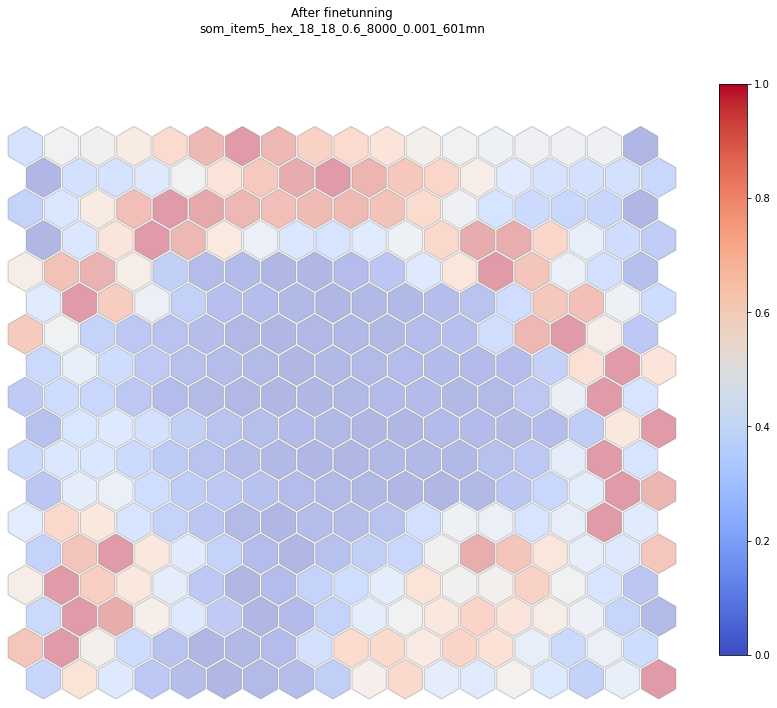

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.016075315298345064
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.047738235996762655
Topographic error not computed.
0.28867513459481287


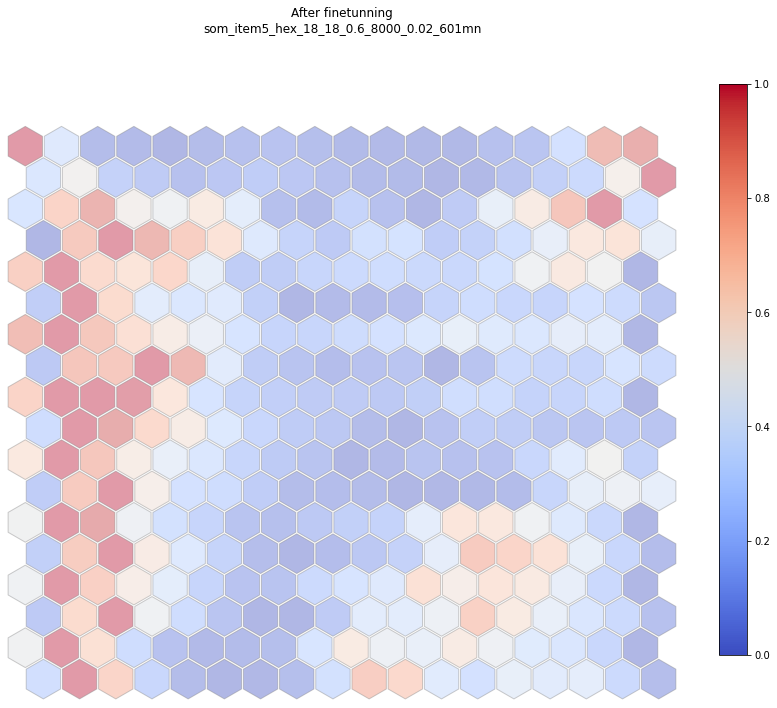

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.016075315298345064
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.046745079264696586
Topographic error not computed.
0.28867513459481287


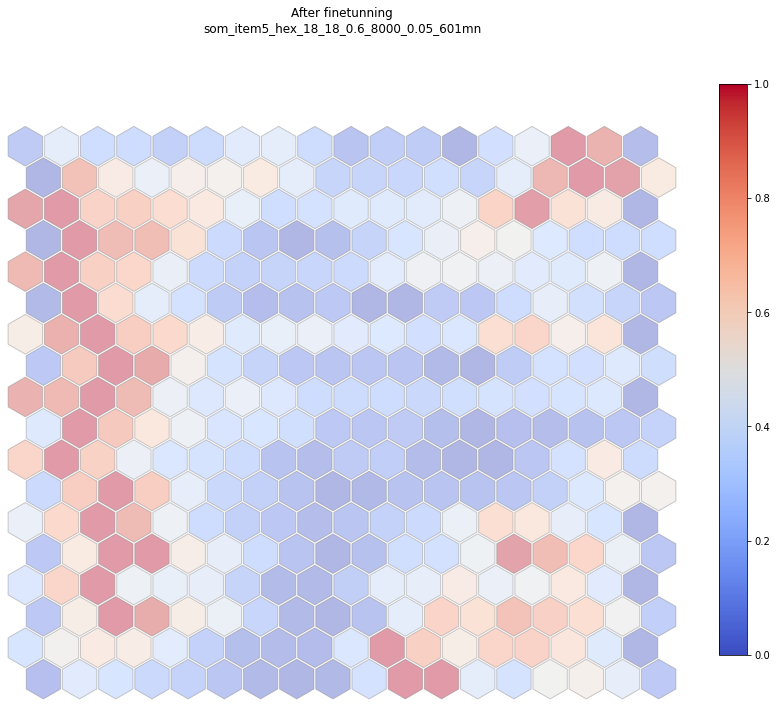

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.016075315298345064
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.048089398838684995
Topographic error not computed.
0.28867513459481287


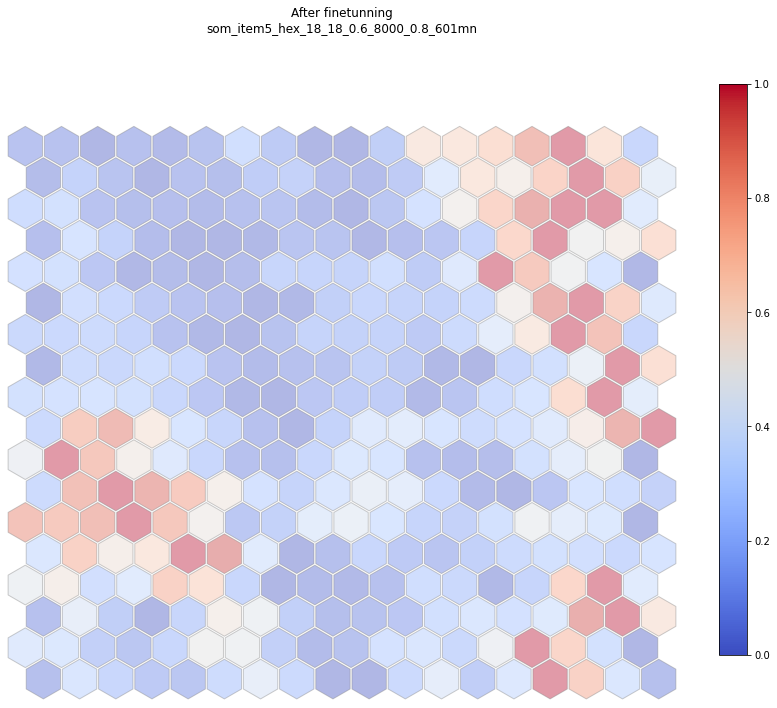

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.016075315298345064
Topographic error not computed.
 [     25 / 194724 ]   0% - 0:05:03 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.04786546345650572
Topographic error not computed.
0.28867513459481287


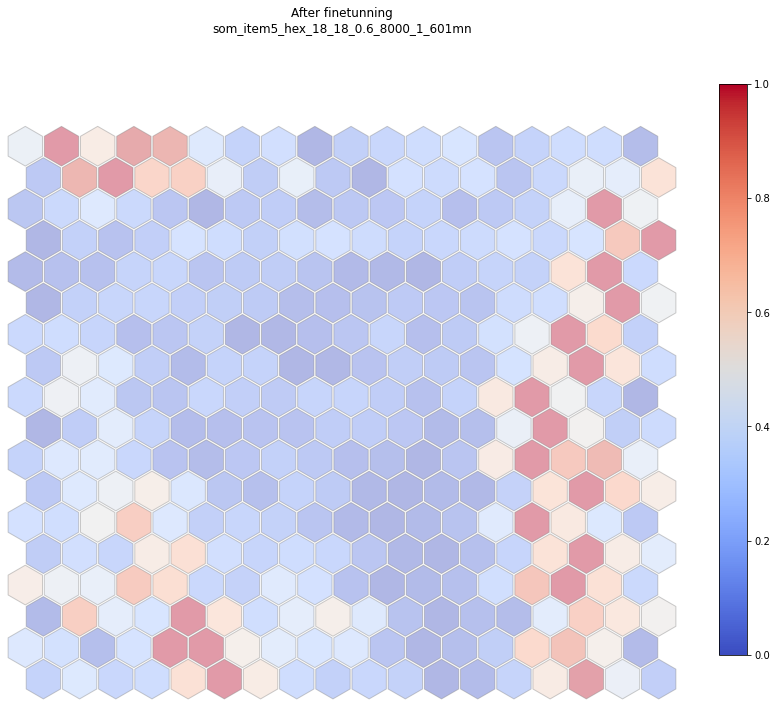

In [177]:
finetuning_learning_rates = [0.001, 0.02, 0.05, 0.8, 1]
rs=222
soms_finetuning_training = [] #salvar modelos

for lr in finetuning_learning_rates:
    s = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    s.pca_weights_init(X)

    sname_file = f'som_item5_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{lr}_{int(finetuning_time/(m*n))}mn'

    s.train_random(X, ordering_time, verbose=True)
    # ************************************************
    # na fase de finetuning modificar lr e decay fcn
    # ************************************************
    s._learning_rate = lr
    s._decay_function = decay_fcn_finetuning

    s.train_random(X, finetuning_time, verbose=True)

    s.plot_umatrix(names=[f'After finetunning\n{sname_file}'])
    soms_finetuning_training.append(s)

    save_som(s, sname_file)
    sname_file

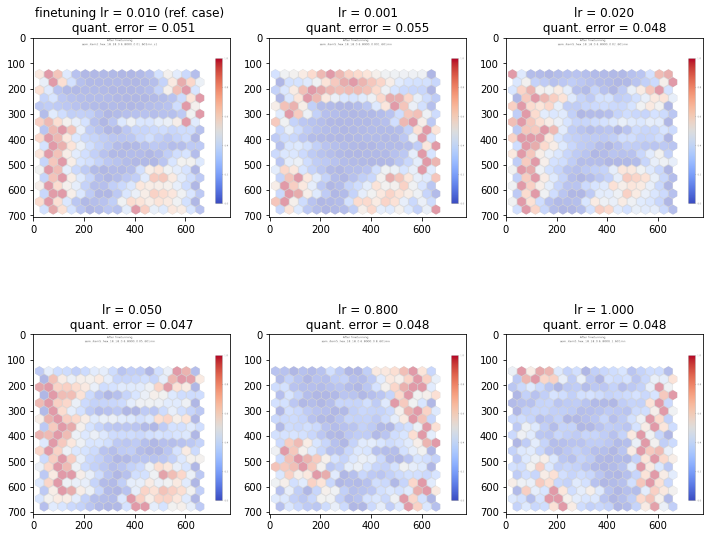

In [178]:
f,axs = plt.subplots(2,3, figsize=(12,10))
axs = axs.flatten()

qerrs = [m._quantization_error[-1] for m in soms_finetuning_training]

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'finetuning lr = {finetuning_lr:.3f} (ref. case) \n quant. error = {soms_topology[2]._quantization_error[-1]:.3f}')

for i in range(5):
    img = mpimg.imread('./maps/item5.'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'lr = {finetuning_learning_rates[i]:.3f}\n quant. error = {qerrs[i]:.3f} ')

#### Resposta:  

> Aparentemente taxas de aprendizagem mais altas na fase de finetuning estão levando a um resultado mais heterogêneo do mapa e um erro de quantização menor, porém aparece uma fronteira de separação mais nítida nos cassos lr = (0.001, 0.02 e 0.05). Tudo isso para o mesmo tempo de treinamento (600 x m x n)

##### 6. Modifique a função de decaimento da taxa de aprendizado. Esta mudança gera algum impacto no mapa gerado? Justifique

Treinando com um decaimento mais rápido/mais lento na fase de ordenação

In [183]:
def decay_fcn_ordering_faster(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    # new_lr = lr/(1 + 2*actual_t/max_t)
    new_lr = lr/(1 + 20*actual_t/max_t)
    return new_lr

def decay_fcn_ordering_slower(lr,actual_t,max_t):
    '''
    Função para decaimento da taxa de aprendizado. 
    
    ## INPUTS:
    lr - Taxa de aprendizado inicial
    actual_t - Tempo atual da iteração
    max_t - Tempo máximo da iteração

    ## OUTPUT:
    - taxa de aprendizado atualizada.
    '''
    # new_lr = lr/(1 + 2*actual_t/max_t)
    new_lr = lr/(1 + 0.2*actual_t/max_t)
    return new_lr

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.04982783025264147
Topographic error not computed.
 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.04141475044977136
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.05156223918335089
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.04709324848682595
Topographic error not computed.
0.28867513459481287


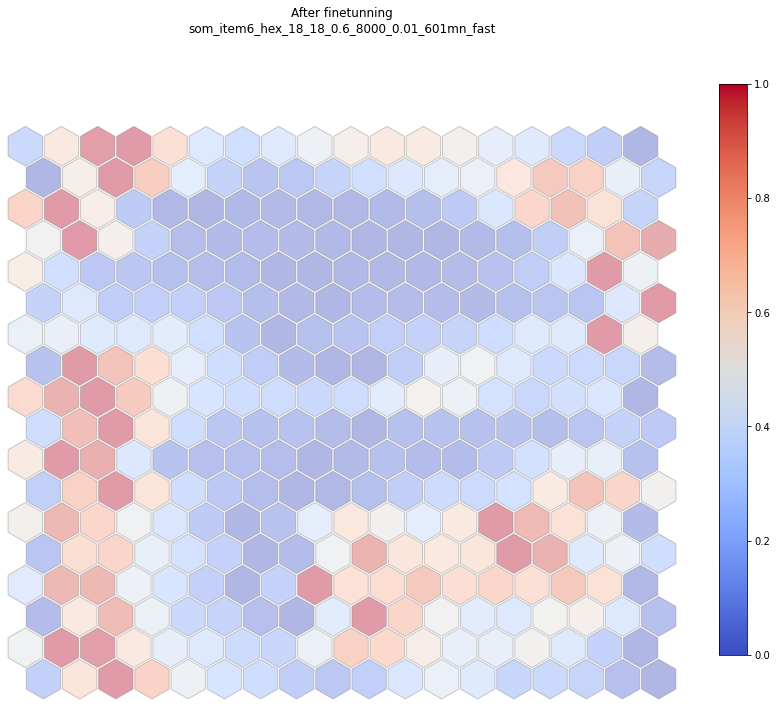

0.28867513459481287


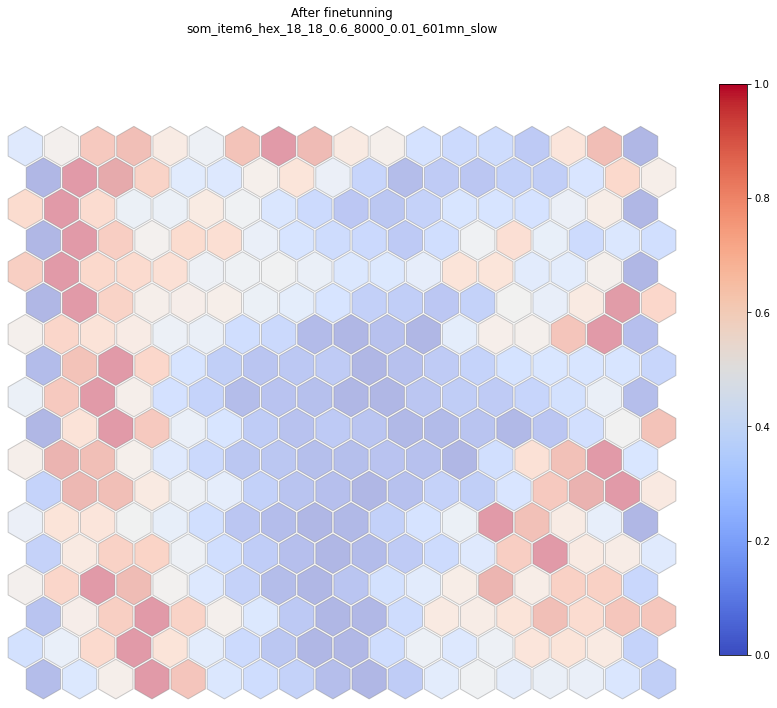

In [184]:
rs = 222

s1 = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering_faster, sigma=1, random_seed=rs)
s2 = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering_slower, sigma=1, random_seed=rs)

s1.pca_weights_init(X)
s2.pca_weights_init(X)

s1name_file = f'som_item6_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn_fast'
s2name_file = f'som_item6_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn_slow'

s1.train_random(X, ordering_time, verbose=True)
s2.train_random(X, ordering_time, verbose=True)
# ************************************************
# na fase de finetuning modificar lr e decay fcn
# ************************************************
s1._learning_rate = finetuning_lr
s1._decay_function = decay_fcn_finetuning
s2._learning_rate = finetuning_lr
s2._decay_function = decay_fcn_finetuning

s1.train_random(X, finetuning_time, verbose=True)
s2.train_random(X, finetuning_time, verbose=True)

s1.plot_umatrix(names=[f'After finetunning\n{s1name_file}'])
s2.plot_umatrix(names=[f'After finetunning\n{s2name_file}'])

save_som(s1, s1name_file)
save_som(s2, s2name_file)

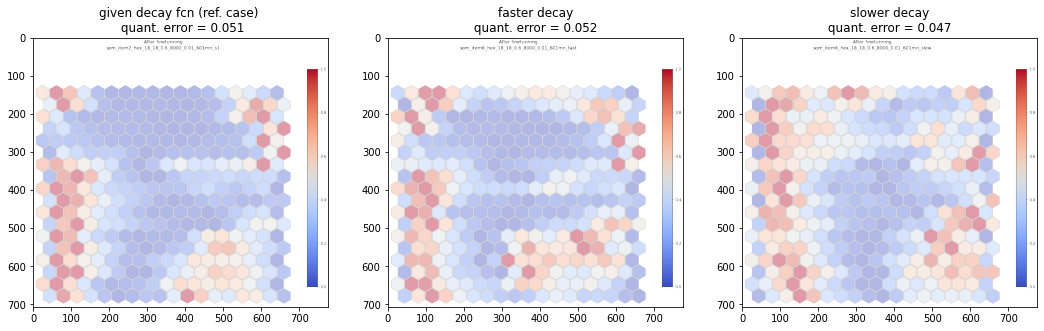

In [190]:
f,axs = plt.subplots(1,3, figsize=(18,12))

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'given decay fcn (ref. case) \n quant. error = {soms_topology[2]._quantization_error[-1]:.3f}')

img = mpimg.imread('./maps/item6.1.png')
axs[1].imshow(img)
axs[1].set(title=f'faster decay\n quant. error = {s1._quantization_error[-1]:.3f} ')

img = mpimg.imread('./maps/item6.2.png')
axs[2].imshow(img)
axs[2].set(title=f'slower decay\n quant. error = {s2._quantization_error[-1]:.3f} ')
pass;

#### Resposta:

Para o tempo de treinamento selecionado, não houve grande impacto na taxa dedecaimento da etapa de ordenação

##### 7. Altere a função de vizinhança. Avalie o resultado.

In [193]:
neighborhood_functions = ['mexican_hat', 'bubble', 'triangle']

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.19090520976367759
Topographic error not computed.
 [ 150828 / 194724 ]  77% - 0:01:12 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:566: RuntimeWarning: overflow encountered in multiply
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


 [ 151013 / 194724 ]  78% - 0:01:12 left 

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:362: RuntimeWarning: overflow encountered in add
  self._weights += einsum('ij, ijk->ijk', g, x-self._weights)


 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: inf
Topographic error not computed.


c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:544: RuntimeWarning: invalid value encountered in true_divide
  return um/um.max()


0.28867513459481287


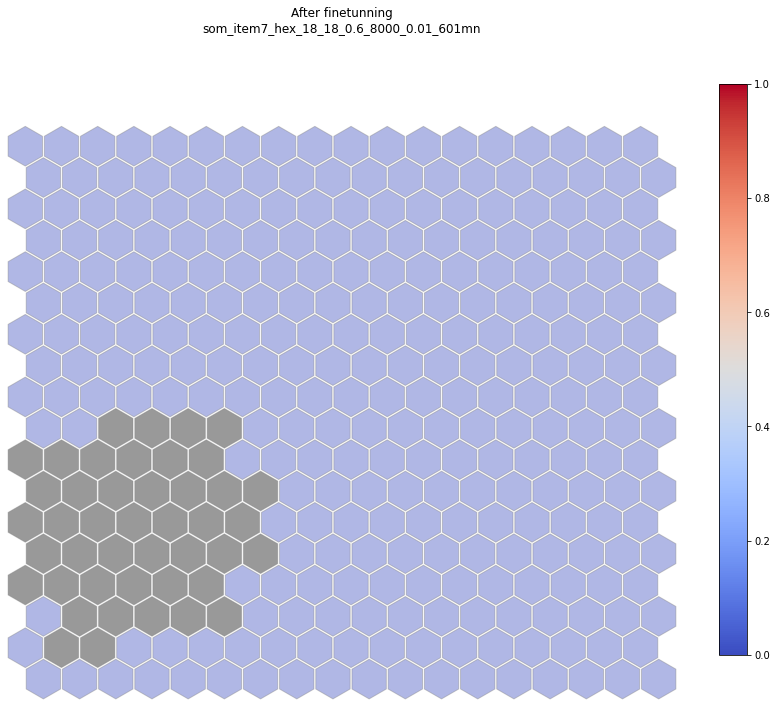

 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.13360596455067744
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.12720646151120615
Topographic error not computed.
0.28867513459481287


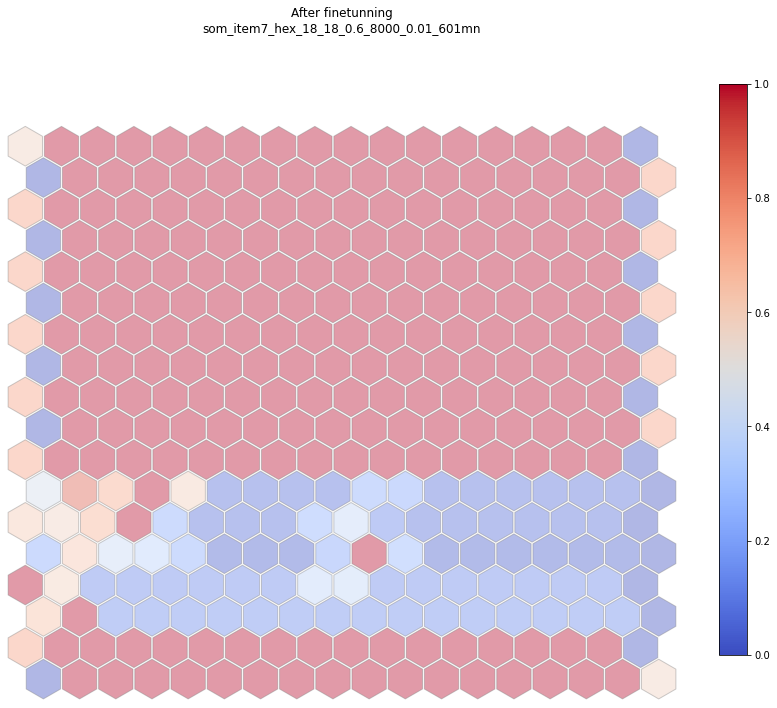

c:\Users\bewm\OneDrive - PETROBRAS\Documents\2_Projetos\MachineLearning\ELE2389_RedesNeurais\minisom\minisom.py:207: UserWarning: triangle neighborhood function does not take in account hexagonal topology
  'take in account hexagonal topology')


 [ 8000 / 8000 ] 100% - 0:00:00 left 
 quantization error: 0.14284377400166387
Topographic error not computed.
 [ 194724 / 194724 ] 100% - 0:00:00 left 
 quantization error: 0.13840019209714363
Topographic error not computed.
0.28867513459481287


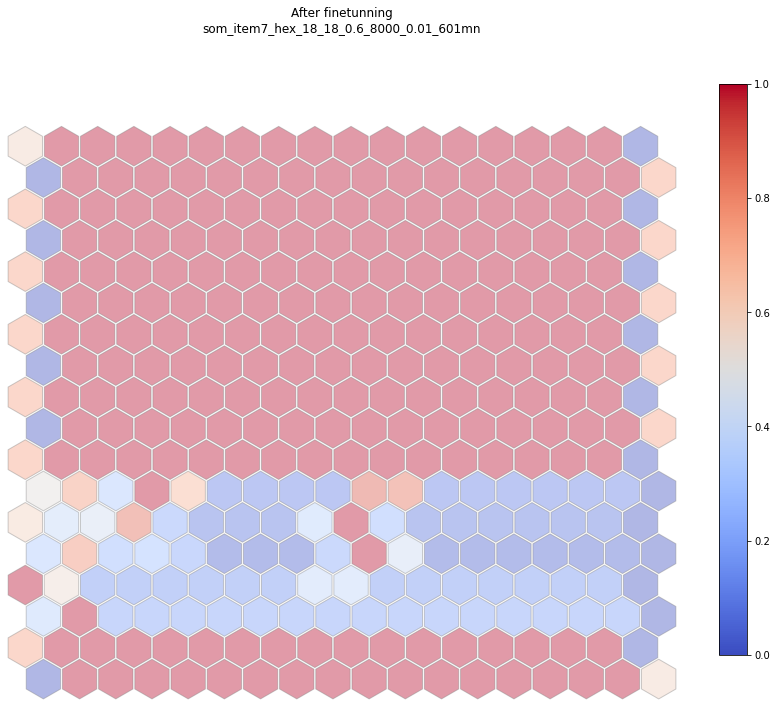

In [194]:
rs=222
soms_neigh = [] #salvar modelos

for nf in neighborhood_functions:
    s = MiniSom(m,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs, neighborhood_function=nf)
    s.pca_weights_init(X)

    sname_file = f'som_item7_{topology[:3]}_{m}_{n}_{ordering_lr}_{ordering_time}_{finetuning_lr}_{int(finetuning_time/(m*n))}mn'

    s.train_random(X, ordering_time, verbose=True)
    
    s._learning_rate = finetuning_lr
    s._decay_function = decay_fcn_finetuning

    s.train_random(X, finetuning_time, verbose=True)

    s.plot_umatrix(names=[f'After finetunning\n{sname_file}'])
    soms_neigh.append(s)

    save_som(s, sname_file)

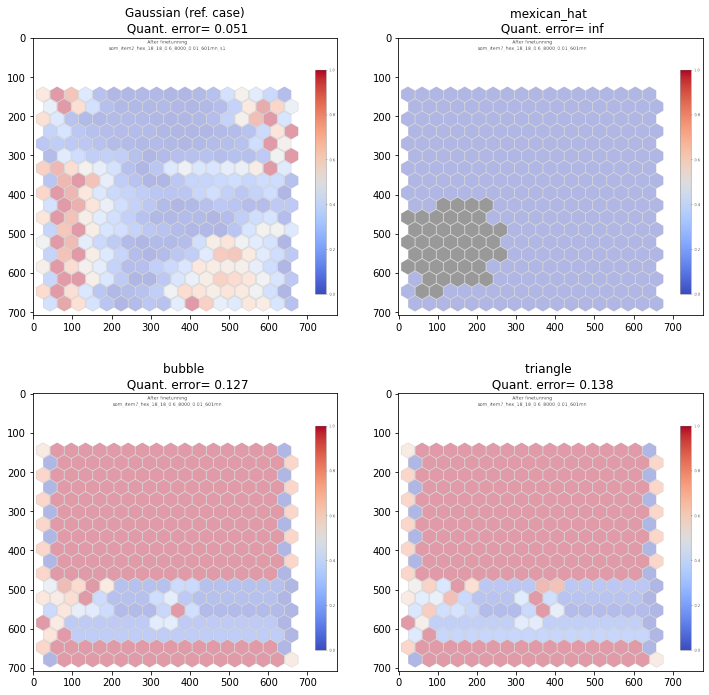

In [195]:
f,axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()

qerrs = [m._quantization_error[-1] for m in soms_neigh]

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'Gaussian (ref. case)\n Quant. error= {soms_topology[2]._quantization_error[-1]:.3f}')

for i in range(3):
    img = mpimg.imread('./maps/item7.'+str(i+1)+'.png')
    axs[i+1].imshow(img)
    axs[i+1].set(title=f'{neighborhood_functions[i]} \n Quant. error= {qerrs[i]:.3f}')

#### Resposta:

> As demais funções apresentaram resultados bem piores do que a Gaussiana (default)

## Parte 2 - Análise dos mapas

##### 1. Teste novas configurações para o modelo SOM para obter um melhor resultado. Justifique a escolha dos parâmetros do modelo selecionado.

> Abordagem 1: A sugestão para essa etapa do estudo é selecionar os melhores casos (a partir de interpretação qualitativa e erro de quantização), para cada um dos itens estudados anteriormente, e, a partir deles, treinar um novo modelo, comparando-o com o caso de referência.
>
> $$\begin{bmatrix} 
Item  & Variável    & Parâmtro      & Melhor Caso (Valor) \\
1     & Topologia   & Dimensões     & m=18, n=18          \\
2     & Topologia   & \sigma        & \sigma=1              \\
3     & Normalização & Scaler        & Min,Max = (-1,1)    \\
4     & Ordering      & Learning Rate  & lr = 0.8    \\
5     & Finetuning    & Learning Rate  & lr = 0.02    \\
6     & Decay Function  & coef.        & coef=2    \\
7     & Neighbor Fcn     & tipo         & Gaussiana    \\
\end{bmatrix}$$
>
> Além disso, vamos fazer um outro caso alternativo treinando a rede por mais tempo

In [ ]:
# new_som = 
ordering_lr_new = .8
finetuning_lr_new = .02
XIN = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)
newsoms = [] #salvar mapas pra depois recuperar

# vamos usar esse looping para treinar por mais tempo nas duas fases do treinamento
for epoch_mult in [1,  1.5]:
    newsom = MiniSom(m,n,input_len,learning_rate=ordering_lr_new,topology=topology,decay_function=decay_fcn_ordering, sigma=1, random_seed=rs)
    newsom.pca_weights_init(XIN)

    sname_file = f'newsom_{topology[:3]}_{m}_{n}_{ordering_lr_new}_{ordering_time*epoch_mult}_{finetuning_lr_new}_{int(finetuning_time*epoch_mult/(m*n))}mn'

    newsom.train_random(XIN, int(ordering_time * epoch_mult), verbose=True)

    newsom._learning_rate = finetuning_lr_new
    newsom._decay_function = decay_fcn_finetuning

    newsom.train_random(XIN, int(finetuning_time * epoch_mult), verbose=True)

    newsom.plot_umatrix(names=[f'After finetunning\n{sname_file}'])
    newsoms.append(newsom)

    save_som(newsom, sname_file)

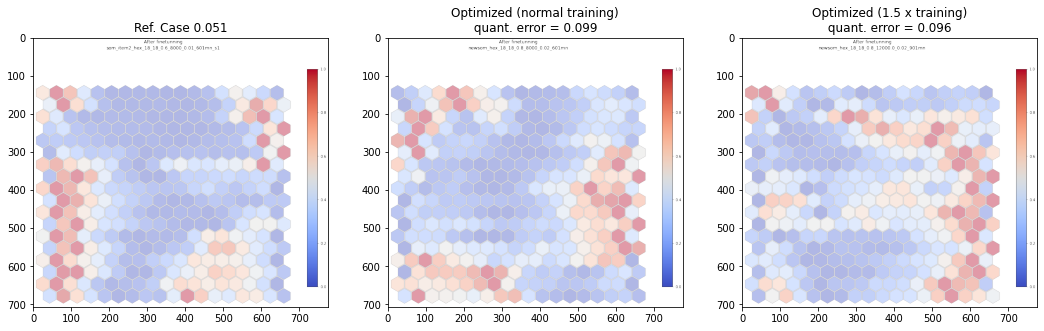

In [250]:
f,axs = plt.subplots(1,3, figsize=(18,12))

#reference case
img = mpimg.imread('./maps/item2.3.png')
axs[0].imshow(img)
axs[0].set(title=f'Ref. Case {som_ref._quantization_error[-1]:.3f}')

img = mpimg.imread('./maps/parte2item1.1.png')
axs[1].imshow(img)
axs[1].set(title=f'Optimized (normal training)\n quant. error = {newsoms[0]._quantization_error[-1]:.3f} ')

img = mpimg.imread('./maps/parte2item1.2.png')
axs[2].imshow(img)
axs[2].set(title=f'Optimized (1.5 x training)\n quant. error = {newsoms[1]._quantization_error[-1]:.3f} ')
pass;

casos ficaram pior, talvez devido a uma má escolha de param

_____

> Abordagem 2: Vamos treinar outras combinações dos parâmetros do mapa  
>

In [172]:
n  = 20

m_ = [36,20,15]
sigma_ = [1, .6]
ft_lr_ = [.1, .02, .006]
# norm_ = [1,0]   # Standard, minmax
# rs_ = [339, 422] # random seed

combinations = product(m_,sigma_,ft_lr_)
combinations = list(combinations)

n_models = len(combinations)

print ('treinaremos', n_models, 'modelos')

treinaremos 18 modelos


Treinando e salvando

In [173]:
# rs=222

dict = {    
    'som'   :   [],
    'q_err' :   [],
    'params':   []
}

X_minmax = MinMaxScaler(feature_range=(-1,1)).fit_transform(X)
# X_stand = StandardScaler().fit_transform(X)

# nas rodadas preliminares entendemos que normalização minmax era melhor
X_input=X_minmax

for i, (m_, sigma_, ft_lr_) in enumerate(combinations):
    print (f'\n model {i+1} / {len(combinations)} ({(i+1)*100/n_models:.1f}%)')
    newsom = MiniSom(m_,n,input_len,learning_rate=ordering_lr,topology=topology,decay_function=decay_fcn_ordering, sigma=sigma_)
    
    newsom.pca_weights_init(X_input)
    newsom.train_random(X_input, 8000, verbose=False)

    newsom._learning_rate = ft_lr_
    newsom._decay_function = decay_fcn_finetuning

    newsom.train_random(X_input, 600*n*m_, verbose=False)

    dict['som'].append(newsom)
    dict['q_err'].append(newsom._quantization_error[-1])
    dict['params'].append((m_, n, sigma_, ft_lr_))

    print (f'>>>>>>>>> params={(m_, n, sigma_, ft_lr_)}')
    print (f'>>>>>>>>> q_err={newsom._quantization_error[-1]:.4f}')
    pass;


 model 1 / 18 (5.6%)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(36, 20, 1, 0.1)
>>>>>>>>> q_err=0.0468

 model 2 / 18 (11.1%)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(36, 20, 1, 0.02)
>>>>>>>>> q_err=0.0813

 model 3 / 18 (16.7%)
Topographic error not computed.
Topographic error not computed.
>>>>>>>>> params=(36, 20, 1, 0.006)
>>>>>>>>> q_err=0.0820

 model 4 / 18 (22.2%)
Topographic error not computed.


KeyboardInterrupt: 

In [ ]:
save_som(dict, 'soms_dict_item_2_1')

In [ ]:
dict

In [ ]:
for i, d in enumerate(dict['som']):
    params = dict['params'][i]    
    quant_error  = dict['q_err'][i]
    d.plot_umatrix(names=[f'model={i+1} \n params={params} \n q_err={quant_error:.3f}'])
    pass;
    

In [125]:
# dict['q_err']
np.asarray(dict['params'])[:,0]


array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 28., 28., 28., 28., 28., 28., 28., 28., 28., 28.,
       28., 28., 28., 28., 28., 28., 40., 40., 40., 40., 40., 40., 40.,
       40., 40., 40., 40., 40., 40., 40., 40., 40.])

<AxesSubplot:>

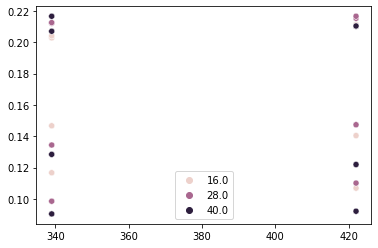

In [142]:
x=np.asarray(dict['params'])[:,4]
h=np.asarray(dict['params'])[:,0]

sns.scatterplot(x=x, y=dict['q_err'], hue=h)

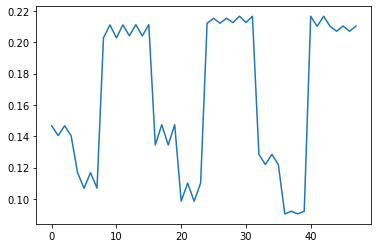

In [60]:
plt.plot(dict['q_err'])


##### 2. Utilizando a melhor configuração do item anterior, analise os diferentes mapas fornecidos e caracterize os grupos de pacientes obtidos.

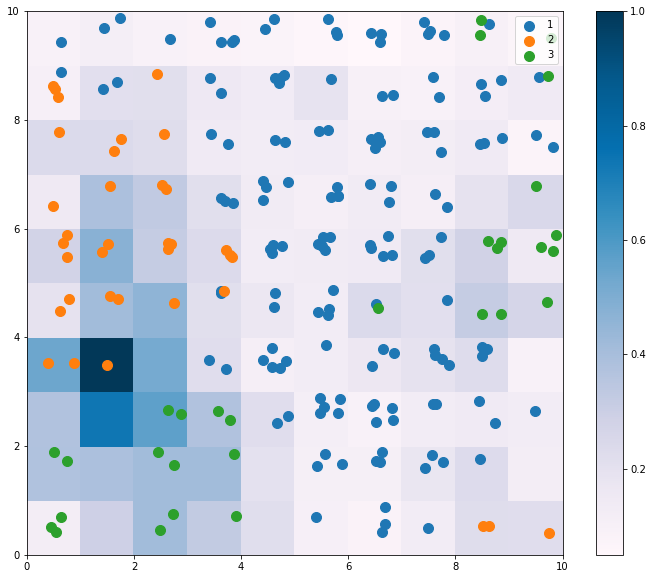

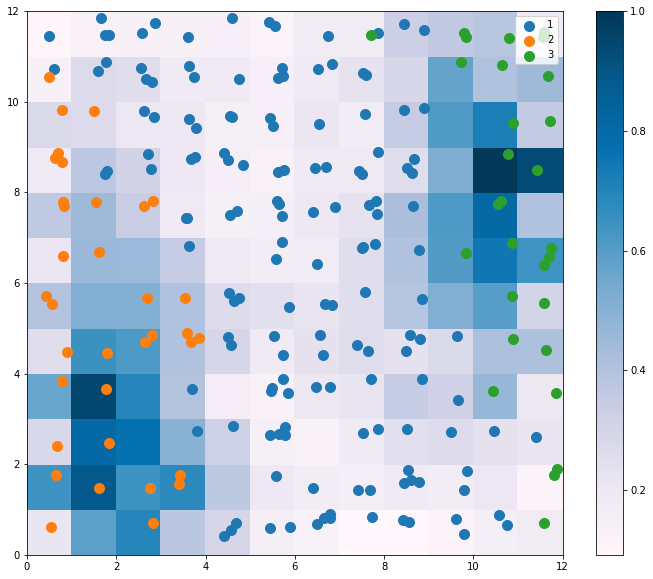

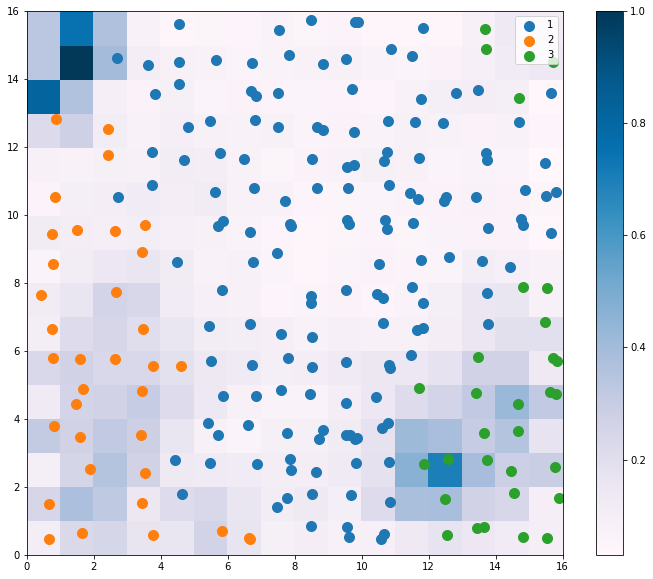

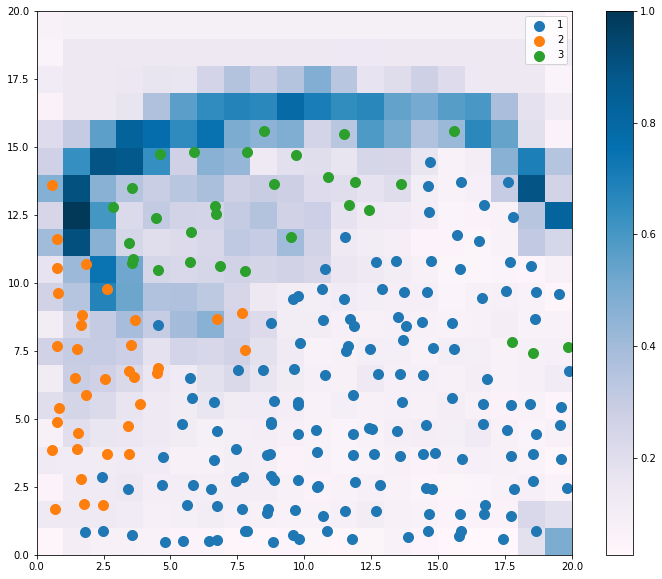

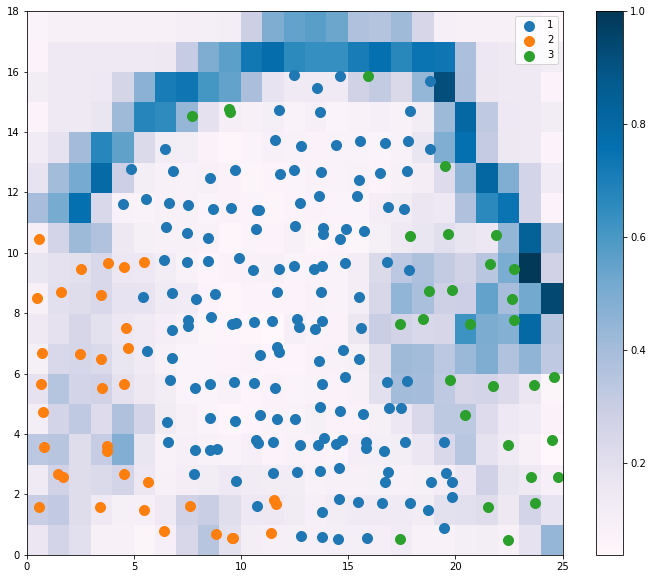

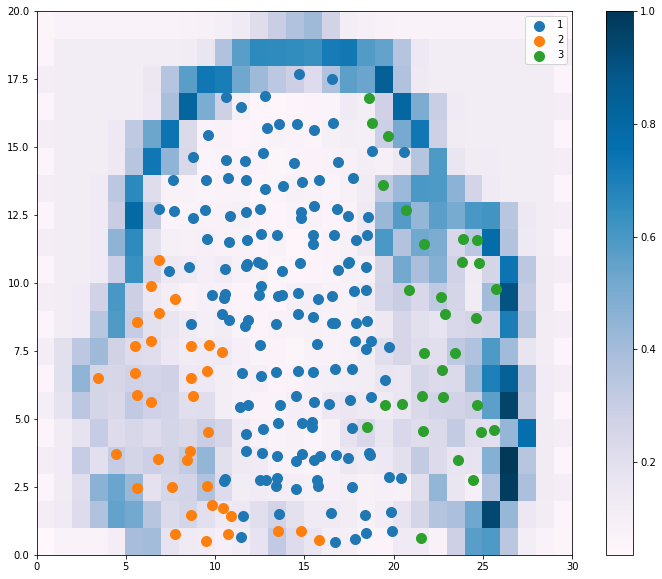

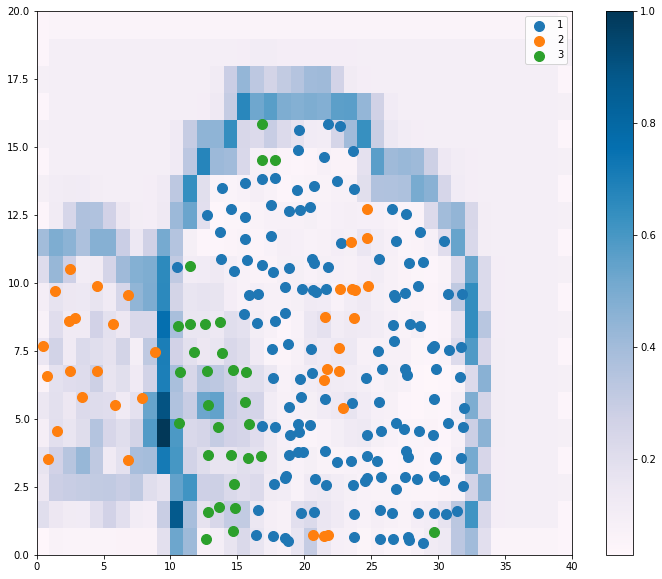

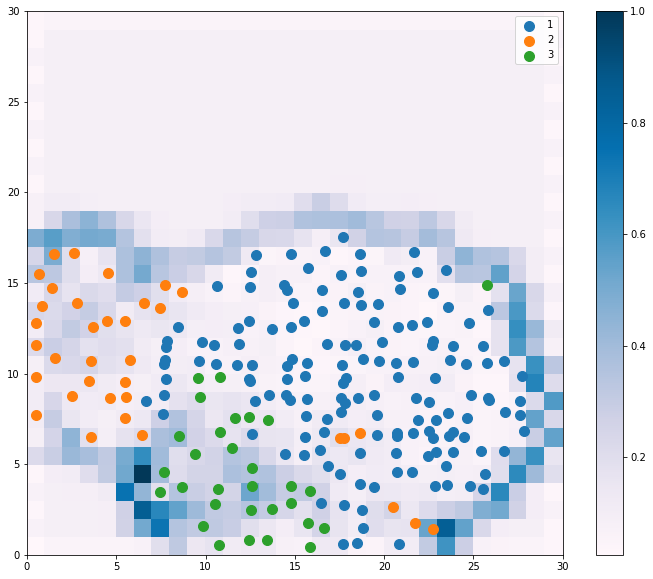

In [37]:
# stest = soms_topology[0]
y=dataset.values[:,-1]
y=y.astype(int)
y_labels = np.unique(y)
colors = ['C0', 'C1', 'C2']
# markers = ['x', 'o', '-']

for stest in dict_mn['som']:
    w_x, w_y = zip(*[stest.winner(d) for d in X])
    w_x = np.array(w_x)
    w_y = np.array(w_y)

    plt.figure(figsize=(12,10))
    plt.pcolor(stest.distance_map().T, cmap='PuBu', alpha=1)
    plt.colorbar()

    for c in np.unique(y):
        idx_y = y==c
        plt.scatter(w_x[idx_y]+.5+(np.random.rand(np.sum(idx_y))-.2)*.5,
                    w_y[idx_y]+.5+(np.random.rand(np.sum(idx_y))-.2)*.5, 
                    s=100, c=colors[c-1], label=y_labels[c-1])
    plt.legend(loc='upper right')
    # plt.grid()
    # plt.savefig('resulting_images/som_seed.png')
    plt.show()
    pass;